In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import cdsapi 
import math

import glob
import sys
import os
import datetime

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import mapping



In [2]:
# check the area

import folium

# Define the coordinates for the corners of the rectangle

#[90, 180, 49, -180]

top_left = (46.5, -72.7)
bottom_right = (46.2, -72.2)


# Create a map centered at the average location
m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2, (top_left[1] + bottom_right[1]) / 2], zoom_start=6)

# Add the rectangle to the map
folium.Rectangle(
    bounds=[top_left, bottom_right],
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.2
).add_to(m)

# Display the map
m

In [19]:
target = '../data/global_temperatures/era5/becancour.nc'
dataset = "reanalysis-era5-single-levels"
request = {
    'product_type': ['reanalysis'],
    'variable': ['2m_dewpoint_temperature', '2m_temperature'],
    'year': ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
    'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
    'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
    'time': ['00:00', '12:00'],
    'data_format': 'netcdf',
    'download_format': 'unarchived',
    'area': [46.5, -72.7, 46.2, -72.2]
}

client = cdsapi.Client()
client.retrieve(dataset, request, target)

2024-08-28 12:21:00,646 INFO Request ID is d18c9420-e3cc-45aa-acdc-0f4f765053c4
2024-08-28 12:21:00,812 INFO status has been updated to accepted
2024-08-28 12:41:24,599 INFO status has been updated to successful


185cef804308238575f52ea8ad821f47.nc:   0%|          | 0.00/0.98M [00:00<?, ?B/s]

'../data/global_temperatures/era5/becancour.nc'

In [31]:
ds = xr.open_dataset(target)
ds_2023 = ds.sel(valid_time=slice('2023-01-01', '2023-12-31'))
print(ds_2023)

<xarray.Dataset> Size: 53kB
Dimensions:     (valid_time: 730, latitude: 2, longitude: 3)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2023-01-01 ... 2023-12-31T12:...
  * latitude    (latitude) float64 16B 46.45 46.2
  * longitude   (longitude) float64 24B -72.7 -72.45 -72.2
    expver      (valid_time) <U4 12kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 18kB ...
    t2m         (valid_time, latitude, longitude) float32 18kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-28T16:07 GRIB to CDM+CF via cfgrib-0.9.1...


In [21]:
# Convert temperatures from Kelvin to Celsius
ds['t2m_c'] = ds['t2m'] - 273.15
ds['d2m_c'] = ds['d2m'] - 273.15

def saturation_vapor_pressure(temp_celsius):
    return 6.112 * np.exp((17.67 * temp_celsius) / (temp_celsius + 243.5))

e_T = saturation_vapor_pressure(ds['t2m_c'])
e_T_dew = saturation_vapor_pressure(ds['d2m_c'])

ds['relative_humidity'] = 100 * (e_T_dew / e_T)

overall_stats = ds[['t2m_c', 'relative_humidity']].to_dataframe().describe()
overall_stats

,t2m_c,relative_humidity,number
count,68568.000000,68568.000000,68568.0
mean,6.067603,75.703751,0.0
std,12.225294,14.828764,0.0
min,-35.791077,4.593051,0.0
25%,-2.256821,66.701084,0.0
50%,6.800629,77.803928,0.0
75%,16.571609,87.326410,0.0
max,30.948822,100.013802,0.0


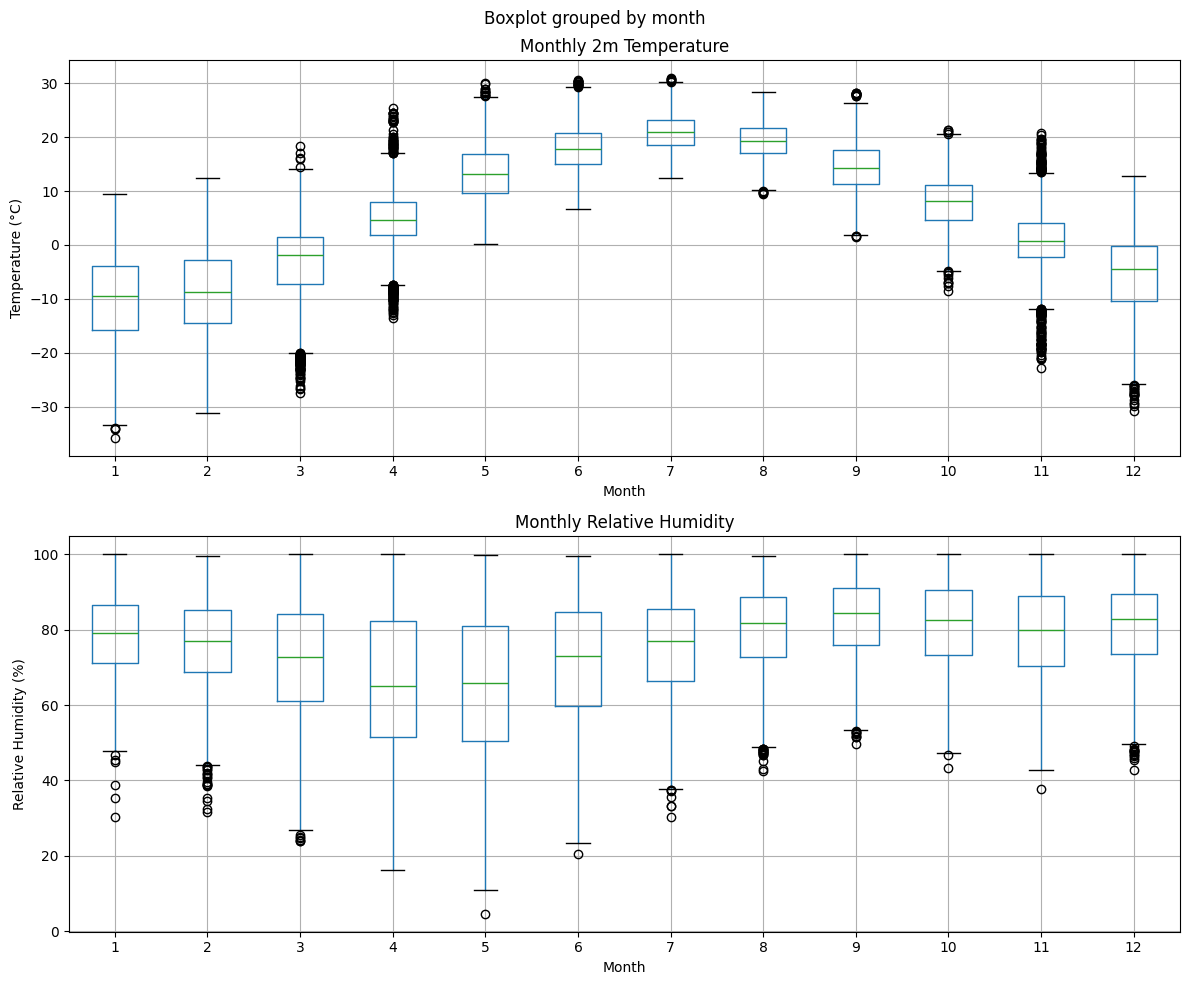

In [30]:

# Extract month from time coordinate
ds['month'] = ds['valid_time'].dt.month
ds = ds.assign_coords(month=ds['month'])

df = ds[['t2m_c', 'relative_humidity']].to_dataframe().reset_index()

# Create box and whisker plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Temperature box plot
df.boxplot(column='t2m_c', by='month', ax=axes[0])
axes[0].set_title('Monthly 2m Temperature')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature (°C)')

# Humidity box plot
df.boxplot(column='relative_humidity', by='month', ax=axes[1])
axes[1].set_title('Monthly Relative Humidity')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Relative Humidity (%)')

plt.tight_layout()
plt.show()
fig.savefig('../data/global_temperatures/era5/temperature_humidity_plot.png')


In [28]:
df = df[['month', 't2m_c', 'relative_humidity']]


# Ensure the columns are numeric
df['t2m_c'] = pd.to_numeric(df['t2m_c'], errors='coerce')
df['relative_humidity'] = pd.to_numeric(df['relative_humidity'], errors='coerce')

# Group by month and calculate statistics
monthly_stats = df.groupby('month').agg(['mean'])

# Output the results in a table
print(monthly_stats)

           t2m_c relative_humidity
            mean              mean
month                             
1     -10.143126         78.676682
2      -8.936346         76.523613
3      -3.240335         72.161026
4       4.822303         65.988609
5      13.413868         64.878693
6      18.011452         71.150337
7      20.922504         75.355324
8      19.334568         80.233551
9      14.455607         83.002121
10      7.963510         81.478996
11      0.705224         79.229553
12     -5.600017         81.157745


In [ ]:
# 2023 Data

# Convert temperatures from Kelvin to Celsius
ds_2023['t2m_c'] = ds_2023['t2m'] - 273.15
ds_2023['d2m_c'] = ds_2023['d2m'] - 273.15

def saturation_vapor_pressure(temp_celsius):
    return 6.112 * np.exp((17.67 * temp_celsius) / (temp_celsius + 243.5))

e_T = saturation_vapor_pressure(ds_2023['t2m_c'])
e_T_dew = saturation_vapor_pressure(ds_2023['d2m_c'])

ds_2023['relative_humidity'] = 100 * (e_T_dew / e_T)

overall_stats = ds_2023[['t2m_c', 'relative_humidity']].to_dataframe().describe()
overall_stats

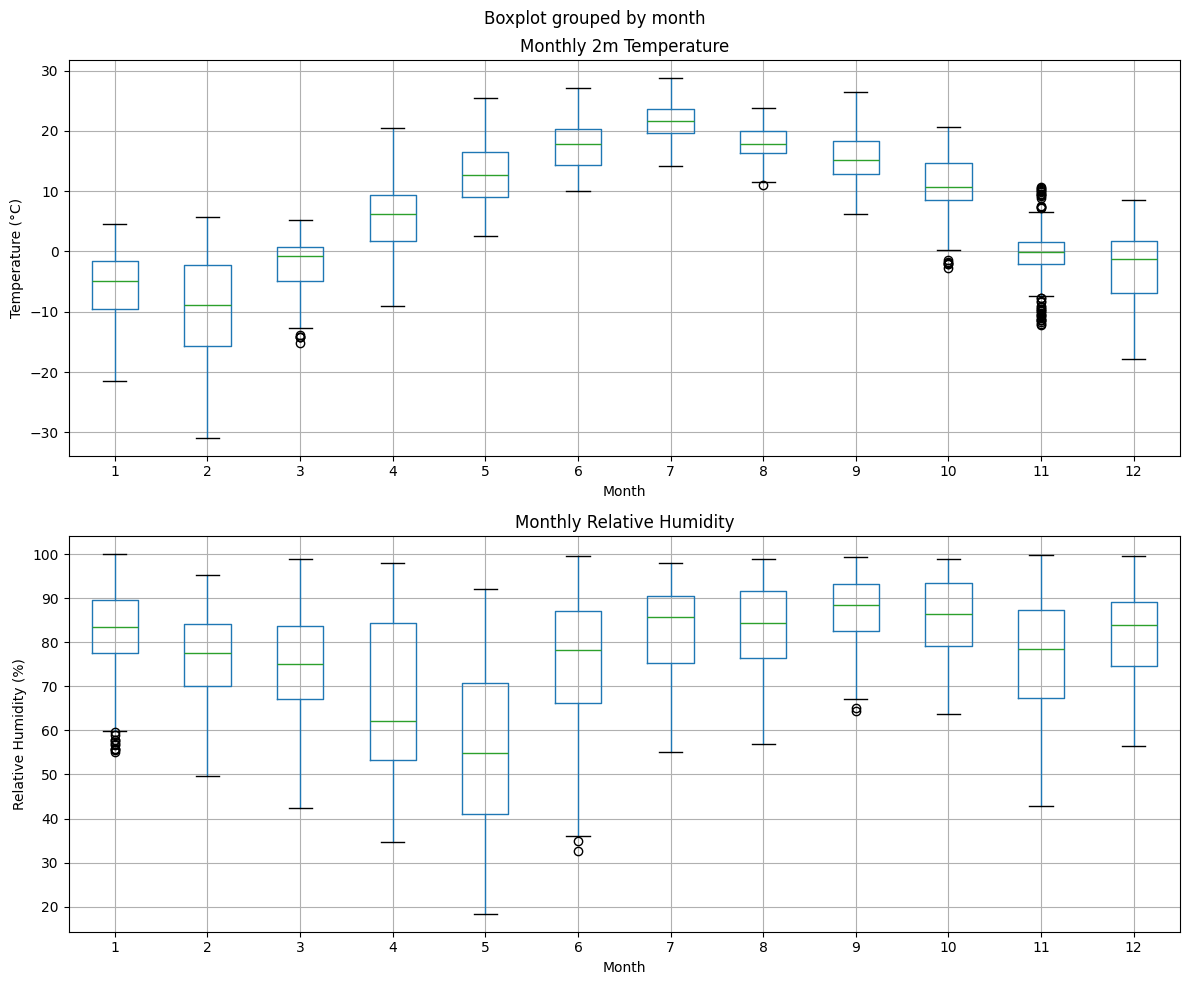

In [39]:

# Extract month from time coordinate
ds_2023['month'] = ds_2023['valid_time'].dt.month
# ds_2023
# ds_2023 = ds_2023.assign_coords(month=ds['month'])
# ds_2023

df_2023 = ds_2023[['t2m_c', 'relative_humidity', 'month']].to_dataframe().reset_index()
df_2023

# Create box and whisker plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Temperature box plot
df_2023.boxplot(column='t2m_c', by='month', ax=axes[0])
axes[0].set_title('Monthly 2m Temperature')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature (°C)')

# Humidity box plot
df_2023.boxplot(column='relative_humidity', by='month', ax=axes[1])
axes[1].set_title('Monthly Relative Humidity')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Relative Humidity (%)')

plt.tight_layout()
plt.show()
fig.savefig('../data/global_temperatures/era5/temperature_humidity_plot_2023.png')


In [41]:
df_2023 = df_2023[['month', 't2m_c', 'relative_humidity']]


# Ensure the columns are numeric
df_2023['t2m_c'] = pd.to_numeric(df_2023['t2m_c'], errors='coerce')
df_2023['relative_humidity'] = pd.to_numeric(df_2023['relative_humidity'], errors='coerce')

# Group by month and calculate statistics
monthly_stats = df_2023.groupby('month').agg(['mean'])

# Output the results in a table
print(monthly_stats)

           t2m_c relative_humidity
            mean              mean
month                             
1      -5.952354         82.858437
2      -9.413854         76.145348
3      -1.986438         74.739899
4       5.774890         66.796066
5      13.034521         56.228668
6      17.690037         75.741104
7      21.604971         82.807869
8      18.001400         83.024643
9      15.746183         87.217018
10     11.080891         85.363625
11     -0.386475         77.679710
12     -2.716444         82.641281
